# Modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Dropout, Normalization, BatchNormalization, LayerNormalization, Input
from tcn import TCN, tcn_full_summary
from catboost import CatBoostRegressor


from sklearn.preprocessing import MinMaxScaler

## Prepare the Data Sets
We want to create two separate datasets; one for our CatBoost model and one for our Keras models.

In [2]:
df = pd.read_parquet("../data/structured/general/combined_data.parquet")
df = df.dropna()
df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,...,Power / vane opening,seconds_since_last_data,seconds_since_last_start,Power / Drafttube pressure,Bolt_1_Tensile_adj,Bolt_2_Tensile_adj,Bolt_3_Tensile_adj,Bolt_4_Tensile_adj,Bolt_5_Tensile_adj,Bolt_6_Tensile_adj
timepoints,,,,,,,,,,,,,,,,,,,,,
1970-12-19 09:51:45,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,1598.477449,1480.989528,1684.261611,1601.366508,...,3.185623,1.0,1.0,1.506435,115.477449,43.989528,72.261611,3.366508,6.588478,38.823883
1970-12-19 09:51:46,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,1598.479316,1481.003188,1684.270504,1601.374254,...,3.184514,1.0,2.0,1.505561,115.479316,44.003188,72.270504,3.374254,6.583464,38.841318
1970-12-19 09:51:47,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,1598.490184,1481.028827,1684.270683,1601.383179,...,3.183404,1.0,3.0,1.504687,115.490184,44.028827,72.270683,3.383179,6.581384,38.843245
1970-12-19 09:51:48,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,1598.494073,1481.059017,1684.271062,1601.378391,...,3.182294,1.0,4.0,1.503294,115.494073,44.059017,72.271062,3.378391,6.591746,38.872300
1970-12-19 09:51:49,261.704362,3.170510,82.266336,174.422046,5312.533396,107.964254,1598.498916,1481.075521,1684.276622,1601.380601,...,3.181184,1.0,5.0,1.500409,115.498916,44.075521,72.276622,3.380601,6.607884,38.924469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,308.716025,3.974309,94.425666,157.927905,5280.929965,108.057498,1637.386115,1504.557822,1701.651420,1606.276545,...,3.269408,1.0,19788.0,1.954791,154.386115,67.557822,89.651420,8.276545,11.704071,54.014705
1971-01-25 11:06:45,308.746393,4.103262,94.429003,157.974925,5280.633358,108.057492,1637.365865,1504.546091,1701.654301,1606.271877,...,3.269614,1.0,19789.0,1.954401,154.365865,67.546091,89.654301,8.271877,11.711250,54.017029
1971-01-25 11:06:46,308.776762,4.472929,94.432340,158.021945,5280.336751,108.057486,1637.384133,1504.538696,1701.656143,1606.250028,...,3.269820,1.0,19790.0,1.954012,154.384133,67.538696,89.656143,8.250028,11.699142,54.002008


In [3]:
y_cols = [c for c in df if c.endswith("Tensile")]
adj_cols = [c for c in df if c.endswith("Tensile_adj")]

### Create CatBoost dataset

In [4]:
extra_cols = ["seconds_since_start", "month", "day_of_month", "day_of_week"]

In [5]:
X_cols = [
    "days_since_start",
    "Turbine_Pressure Drafttube",
    "seconds_since_last_start",
    ""
]

In [6]:
lookback = 0

cX = df.drop(columns=y_cols+adj_cols)
X_cols = cX.drop(columns=extra_cols).columns
for i in range(1, lookback+1):
    cX.loc[:, [f"{c} (t-{i})" for c in X_cols]] = cX[X_cols].shift(i).rename(columns={c: f"{c} (t-{i})" for c in X_cols})

cy = df[y_cols]

cX

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,seconds_since_start,month,day_of_month,day_of_week,is_starting,Netto Power,Power / vane opening,seconds_since_last_data,seconds_since_last_start,Power / Drafttube pressure
timepoints,,,,,,,,,,,,,,,,
1970-12-19 09:51:45,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,1.0,12,19,5,0,258.759689,3.185623,1.0,1.0,1.506435
1970-12-19 09:51:46,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,2.0,12,19,5,0,258.214106,3.184514,1.0,2.0,1.505561
1970-12-19 09:51:47,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,3.0,12,19,5,0,257.668524,3.183404,1.0,3.0,1.504687
1970-12-19 09:51:48,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,4.0,12,19,5,0,257.739592,3.182294,1.0,4.0,1.503294
1970-12-19 09:51:49,261.704362,3.170510,82.266336,174.422046,5312.533396,107.964254,5.0,12,19,5,0,258.533851,3.181184,1.0,5.0,1.500409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,308.716025,3.974309,94.425666,157.927905,5280.929965,108.057498,2769300.0,1,25,0,0,304.741716,3.269408,1.0,19788.0,1.954791
1971-01-25 11:06:45,308.746393,4.103262,94.429003,157.974925,5280.633358,108.057492,2769301.0,1,25,0,0,304.643131,3.269614,1.0,19789.0,1.954401
1971-01-25 11:06:46,308.776762,4.472929,94.432340,158.021945,5280.336751,108.057486,2769302.0,1,25,0,0,304.303833,3.269820,1.0,19790.0,1.954012


In [7]:
def train_test_split(X, y, test_percent=0.1, offset_percent=0):
    
    test_start = int(len(df) * offset_percent)
    test_end = int(len(df) * (offset_percent + test_percent))

    train = df.iloc[:test_start]
    test = df.iloc[test_start:test_end]

    X_train, X_test = X.iloc[:test_start], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:test_start], y.iloc[test_start:test_end]
    
    return X_train, X_test, y_train, y_test

cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_percent=0.1, offset_percent=0.9)

### CatBoost Modeling

In [8]:
def train_catboost(X_train, y_train, eval_set=None, params={}):
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=eval_set)
    
    return model

In [9]:
def plot_error(X_test, y_test, model):

    y_test = y_tests[j].copy()

    pred = model.predict(X_test)

    plt.subplots(figsize=(15, 10))
    plt.scatter(y_test.index, y_test, label="real", s=2)
    plt.scatter(y_test.index, pred, label="pred", s=2)
    plt.legend()
    plt.show()

In [36]:
def cv_catboost(X, y, n=4, start_offset=0.5, verbose=False, params={}):

    test_percent = (1 - start_offset) / n

    all_results = []
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_percent = test_percent,
                                                            offset_percent = start_offset + i*test_percent)
        y_trains = [y_train[c] for c in y_train]
        y_tests = [y_test[c] for c in y_test]

        results = []
        for j in range(len(y_trains)):
            model = CatBoostRegressor(**params)
            model.fit(X_train, y_trains[j], eval_set=(X_test, y_tests[j]), verbose=verbose)

            pred = model.predict(X_test)
            mape = 100 * ((y_tests[j] - pred).abs() / y_tests[j]).mean()
            results.append(mape)
            print(f"iteration {i}, bolt {j}: MAPE={mape}")
        all_results.append(results)
    all_results = np.array(all_results)
    
    return all_results

params = {
    "loss_function": "MAPE",
    "iterations": 200,
    "depth": 6
}

results = cv_catboost(cX, cy, params=params, verbose=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.0013944	test: 0.0062062	best: 0.0062062 (0)	total: 129ms	remaining: 25.6s
1:	learn: 0.0013618	test: 0.0060844	best: 0.0060844 (1)	total: 239ms	remaining: 23.6s
2:	learn: 0.0013291	test: 0.0059662	best: 0.0059662 (2)	total: 346ms	remaining: 22.7s
3:	learn: 0.0012996	test: 0.0059235	best: 0.0059235 (3)	total: 455ms	remaining: 22.3s
4:	learn: 0.0012700	test: 0.0058541	best: 0.0058541 (4)	total: 583ms	remaining: 22.7s
5:	learn: 0.0012381	test: 0.0057977	best: 0.0057977 (5)	total: 714ms	remaining: 23.1s
6:	learn: 0.0012121	test: 0.0057676	best: 0.0057676 (6)	total: 843ms	remaining: 23.2s
7:	learn: 0.0011830	test: 0.0056566	best: 0.0056566 (7)	total: 953ms	remaining: 22.9s
8:	learn: 0.0011571	test: 0.0056255	best: 0.0056255 (8)	total: 1.06s	remaining: 22.5s
9:	learn: 0.0011291	test: 0.0055662	best: 0.0055662 (9)	total: 1.18s	remaining: 22.5s
10:	learn: 0.0011023	test: 0.0055096	best: 0.0055096 (10)	total: 1.29s	remaining: 22.2s
11:	learn: 0.0010777	test: 0.0054546	best: 0.0054546

95:	learn: 0.0001787	test: 0.0033291	best: 0.0033291 (95)	total: 12.1s	remaining: 13.1s
96:	learn: 0.0001759	test: 0.0033228	best: 0.0033228 (96)	total: 12.2s	remaining: 13s
97:	learn: 0.0001732	test: 0.0033162	best: 0.0033162 (97)	total: 12.3s	remaining: 12.8s
98:	learn: 0.0001707	test: 0.0033104	best: 0.0033104 (98)	total: 12.4s	remaining: 12.7s
99:	learn: 0.0001682	test: 0.0033042	best: 0.0033042 (99)	total: 12.6s	remaining: 12.6s
100:	learn: 0.0001660	test: 0.0032988	best: 0.0032988 (100)	total: 12.7s	remaining: 12.5s
101:	learn: 0.0001638	test: 0.0032937	best: 0.0032937 (101)	total: 12.8s	remaining: 12.3s
102:	learn: 0.0001614	test: 0.0032844	best: 0.0032844 (102)	total: 13s	remaining: 12.2s
103:	learn: 0.0001593	test: 0.0032791	best: 0.0032791 (103)	total: 13.1s	remaining: 12.1s
104:	learn: 0.0001573	test: 0.0032739	best: 0.0032739 (104)	total: 13.2s	remaining: 12s
105:	learn: 0.0001553	test: 0.0032685	best: 0.0032685 (105)	total: 13.4s	remaining: 11.9s
106:	learn: 0.0001537	test

187:	learn: 0.0000838	test: 0.0026974	best: 0.0026974 (187)	total: 23.9s	remaining: 1.52s
188:	learn: 0.0000835	test: 0.0026920	best: 0.0026920 (188)	total: 24s	remaining: 1.4s
189:	learn: 0.0000833	test: 0.0026907	best: 0.0026907 (189)	total: 24.2s	remaining: 1.27s
190:	learn: 0.0000831	test: 0.0026890	best: 0.0026890 (190)	total: 24.3s	remaining: 1.14s
191:	learn: 0.0000829	test: 0.0026877	best: 0.0026877 (191)	total: 24.4s	remaining: 1.02s
192:	learn: 0.0000827	test: 0.0026873	best: 0.0026873 (192)	total: 24.5s	remaining: 890ms
193:	learn: 0.0000826	test: 0.0026871	best: 0.0026871 (193)	total: 24.7s	remaining: 764ms
194:	learn: 0.0000824	test: 0.0026864	best: 0.0026864 (194)	total: 24.8s	remaining: 637ms
195:	learn: 0.0000822	test: 0.0026807	best: 0.0026807 (195)	total: 25s	remaining: 510ms
196:	learn: 0.0000819	test: 0.0026758	best: 0.0026758 (196)	total: 25.1s	remaining: 383ms
197:	learn: 0.0000817	test: 0.0026713	best: 0.0026713 (197)	total: 25.3s	remaining: 255ms
198:	learn: 0.0

80:	learn: 0.0002023	test: 0.0016078	best: 0.0016078 (80)	total: 10.7s	remaining: 15.7s
81:	learn: 0.0001986	test: 0.0015872	best: 0.0015872 (81)	total: 10.8s	remaining: 15.6s
82:	learn: 0.0001955	test: 0.0015567	best: 0.0015567 (82)	total: 11s	remaining: 15.4s
83:	learn: 0.0001921	test: 0.0015365	best: 0.0015365 (83)	total: 11.1s	remaining: 15.3s
84:	learn: 0.0001887	test: 0.0015235	best: 0.0015235 (84)	total: 11.2s	remaining: 15.1s
85:	learn: 0.0001860	test: 0.0015108	best: 0.0015108 (85)	total: 11.3s	remaining: 15s
86:	learn: 0.0001830	test: 0.0014944	best: 0.0014944 (86)	total: 11.5s	remaining: 14.9s
87:	learn: 0.0001798	test: 0.0014736	best: 0.0014736 (87)	total: 11.6s	remaining: 14.7s
88:	learn: 0.0001769	test: 0.0014453	best: 0.0014453 (88)	total: 11.7s	remaining: 14.6s
89:	learn: 0.0001744	test: 0.0014304	best: 0.0014304 (89)	total: 11.8s	remaining: 14.4s
90:	learn: 0.0001719	test: 0.0014192	best: 0.0014192 (90)	total: 11.9s	remaining: 14.3s
91:	learn: 0.0001696	test: 0.0014035

172:	learn: 0.0000939	test: 0.0009295	best: 0.0009295 (172)	total: 22.3s	remaining: 3.49s
173:	learn: 0.0000935	test: 0.0009281	best: 0.0009281 (173)	total: 22.5s	remaining: 3.35s
174:	learn: 0.0000931	test: 0.0009229	best: 0.0009229 (174)	total: 22.6s	remaining: 3.23s
175:	learn: 0.0000928	test: 0.0009186	best: 0.0009186 (175)	total: 22.7s	remaining: 3.1s
176:	learn: 0.0000925	test: 0.0009156	best: 0.0009156 (176)	total: 22.9s	remaining: 2.97s
177:	learn: 0.0000922	test: 0.0009116	best: 0.0009116 (177)	total: 23s	remaining: 2.85s
178:	learn: 0.0000918	test: 0.0009072	best: 0.0009072 (178)	total: 23.2s	remaining: 2.72s
179:	learn: 0.0000916	test: 0.0009054	best: 0.0009054 (179)	total: 23.3s	remaining: 2.59s
180:	learn: 0.0000913	test: 0.0009010	best: 0.0009010 (180)	total: 23.4s	remaining: 2.46s
181:	learn: 0.0000910	test: 0.0008967	best: 0.0008967 (181)	total: 23.6s	remaining: 2.33s
182:	learn: 0.0000907	test: 0.0008962	best: 0.0008962 (182)	total: 23.7s	remaining: 2.2s
183:	learn: 0.

64:	learn: 0.0001144	test: 0.0016987	best: 0.0016987 (64)	total: 7.5s	remaining: 15.6s
65:	learn: 0.0001124	test: 0.0016936	best: 0.0016936 (65)	total: 7.61s	remaining: 15.5s
66:	learn: 0.0001104	test: 0.0016882	best: 0.0016882 (66)	total: 7.73s	remaining: 15.3s
67:	learn: 0.0001087	test: 0.0016840	best: 0.0016840 (67)	total: 7.83s	remaining: 15.2s
68:	learn: 0.0001068	test: 0.0016790	best: 0.0016790 (68)	total: 7.95s	remaining: 15.1s
69:	learn: 0.0001051	test: 0.0016738	best: 0.0016738 (69)	total: 8.05s	remaining: 15s
70:	learn: 0.0001035	test: 0.0016690	best: 0.0016690 (70)	total: 8.19s	remaining: 14.9s
71:	learn: 0.0001017	test: 0.0016634	best: 0.0016634 (71)	total: 8.31s	remaining: 14.8s
72:	learn: 0.0001001	test: 0.0016581	best: 0.0016581 (72)	total: 8.42s	remaining: 14.7s
73:	learn: 0.0000986	test: 0.0016540	best: 0.0016540 (73)	total: 8.55s	remaining: 14.6s
74:	learn: 0.0000970	test: 0.0016495	best: 0.0016495 (74)	total: 8.65s	remaining: 14.4s
75:	learn: 0.0000955	test: 0.001645

158:	learn: 0.0000494	test: 0.0013806	best: 0.0013806 (158)	total: 18.1s	remaining: 4.66s
159:	learn: 0.0000493	test: 0.0013797	best: 0.0013797 (159)	total: 18.2s	remaining: 4.55s
160:	learn: 0.0000492	test: 0.0013782	best: 0.0013782 (160)	total: 18.3s	remaining: 4.43s
161:	learn: 0.0000490	test: 0.0013767	best: 0.0013767 (161)	total: 18.4s	remaining: 4.32s
162:	learn: 0.0000488	test: 0.0013734	best: 0.0013734 (162)	total: 18.5s	remaining: 4.2s
163:	learn: 0.0000486	test: 0.0013710	best: 0.0013710 (163)	total: 18.6s	remaining: 4.09s
164:	learn: 0.0000484	test: 0.0013675	best: 0.0013675 (164)	total: 18.8s	remaining: 3.98s
165:	learn: 0.0000482	test: 0.0013655	best: 0.0013655 (165)	total: 18.9s	remaining: 3.86s
166:	learn: 0.0000480	test: 0.0013647	best: 0.0013647 (166)	total: 19s	remaining: 3.75s
167:	learn: 0.0000478	test: 0.0013628	best: 0.0013628 (167)	total: 19.1s	remaining: 3.63s
168:	learn: 0.0000477	test: 0.0013631	best: 0.0013628 (167)	total: 19.2s	remaining: 3.52s
169:	learn: 0

50:	learn: 0.0001942	test: 0.0005800	best: 0.0005800 (50)	total: 5.87s	remaining: 17.1s
51:	learn: 0.0001921	test: 0.0005709	best: 0.0005709 (51)	total: 5.97s	remaining: 17s
52:	learn: 0.0001900	test: 0.0005660	best: 0.0005660 (52)	total: 6.08s	remaining: 16.9s
53:	learn: 0.0001872	test: 0.0005630	best: 0.0005630 (53)	total: 6.19s	remaining: 16.7s
54:	learn: 0.0001855	test: 0.0005586	best: 0.0005586 (54)	total: 6.3s	remaining: 16.6s
55:	learn: 0.0001829	test: 0.0005488	best: 0.0005488 (55)	total: 6.42s	remaining: 16.5s
56:	learn: 0.0001801	test: 0.0005435	best: 0.0005435 (56)	total: 6.53s	remaining: 16.4s
57:	learn: 0.0001772	test: 0.0005418	best: 0.0005418 (57)	total: 6.64s	remaining: 16.3s
58:	learn: 0.0001747	test: 0.0005394	best: 0.0005394 (58)	total: 6.75s	remaining: 16.1s
59:	learn: 0.0001720	test: 0.0005359	best: 0.0005359 (59)	total: 6.87s	remaining: 16s
60:	learn: 0.0001701	test: 0.0005305	best: 0.0005305 (60)	total: 6.97s	remaining: 15.9s
61:	learn: 0.0001678	test: 0.0005263	

144:	learn: 0.0000734	test: 0.0003432	best: 0.0003432 (144)	total: 16.3s	remaining: 6.19s
145:	learn: 0.0000731	test: 0.0003427	best: 0.0003427 (145)	total: 16.4s	remaining: 6.07s
146:	learn: 0.0000728	test: 0.0003424	best: 0.0003424 (146)	total: 16.5s	remaining: 5.97s
147:	learn: 0.0000725	test: 0.0003419	best: 0.0003419 (147)	total: 16.7s	remaining: 5.85s
148:	learn: 0.0000721	test: 0.0003417	best: 0.0003417 (148)	total: 16.8s	remaining: 5.75s
149:	learn: 0.0000718	test: 0.0003415	best: 0.0003415 (149)	total: 16.9s	remaining: 5.64s
150:	learn: 0.0000714	test: 0.0003403	best: 0.0003403 (150)	total: 17s	remaining: 5.52s
151:	learn: 0.0000711	test: 0.0003375	best: 0.0003375 (151)	total: 17.1s	remaining: 5.41s
152:	learn: 0.0000708	test: 0.0003368	best: 0.0003368 (152)	total: 17.3s	remaining: 5.3s
153:	learn: 0.0000706	test: 0.0003365	best: 0.0003365 (153)	total: 17.4s	remaining: 5.19s
154:	learn: 0.0000703	test: 0.0003369	best: 0.0003365 (153)	total: 17.5s	remaining: 5.08s
155:	learn: 0

37:	learn: 0.0002011	test: 0.0006487	best: 0.0006487 (37)	total: 4.31s	remaining: 18.4s
38:	learn: 0.0001988	test: 0.0006458	best: 0.0006458 (38)	total: 4.43s	remaining: 18.3s
39:	learn: 0.0001966	test: 0.0006431	best: 0.0006431 (39)	total: 4.54s	remaining: 18.2s
40:	learn: 0.0001945	test: 0.0006425	best: 0.0006425 (40)	total: 4.64s	remaining: 18s
41:	learn: 0.0001914	test: 0.0006374	best: 0.0006374 (41)	total: 4.76s	remaining: 17.9s
42:	learn: 0.0001886	test: 0.0006364	best: 0.0006364 (42)	total: 4.87s	remaining: 17.8s
43:	learn: 0.0001867	test: 0.0006354	best: 0.0006354 (43)	total: 4.97s	remaining: 17.6s
44:	learn: 0.0001848	test: 0.0006349	best: 0.0006349 (44)	total: 5.08s	remaining: 17.5s
45:	learn: 0.0001819	test: 0.0006301	best: 0.0006301 (45)	total: 5.17s	remaining: 17.3s
46:	learn: 0.0001794	test: 0.0006230	best: 0.0006230 (46)	total: 5.3s	remaining: 17.3s
47:	learn: 0.0001764	test: 0.0006228	best: 0.0006228 (47)	total: 5.41s	remaining: 17.1s
48:	learn: 0.0001742	test: 0.000623

130:	learn: 0.0000725	test: 0.0005102	best: 0.0005102 (130)	total: 15s	remaining: 7.92s
131:	learn: 0.0000722	test: 0.0005094	best: 0.0005094 (131)	total: 15.1s	remaining: 7.8s
132:	learn: 0.0000717	test: 0.0005086	best: 0.0005086 (132)	total: 15.3s	remaining: 7.69s
133:	learn: 0.0000715	test: 0.0005082	best: 0.0005082 (133)	total: 15.4s	remaining: 7.57s
134:	learn: 0.0000712	test: 0.0005080	best: 0.0005080 (134)	total: 15.5s	remaining: 7.45s
135:	learn: 0.0000709	test: 0.0005098	best: 0.0005080 (134)	total: 15.6s	remaining: 7.34s
136:	learn: 0.0000706	test: 0.0005096	best: 0.0005080 (134)	total: 15.7s	remaining: 7.22s
137:	learn: 0.0000701	test: 0.0005092	best: 0.0005080 (134)	total: 15.8s	remaining: 7.11s
138:	learn: 0.0000698	test: 0.0005084	best: 0.0005080 (134)	total: 15.9s	remaining: 6.99s
139:	learn: 0.0000694	test: 0.0005098	best: 0.0005080 (134)	total: 16s	remaining: 6.87s
140:	learn: 0.0000691	test: 0.0005093	best: 0.0005080 (134)	total: 16.1s	remaining: 6.75s
141:	learn: 0.0

22:	learn: 0.0002697	test: 0.0019070	best: 0.0019070 (22)	total: 2.82s	remaining: 21.7s
23:	learn: 0.0002658	test: 0.0019030	best: 0.0019030 (23)	total: 2.94s	remaining: 21.6s
24:	learn: 0.0002619	test: 0.0019000	best: 0.0019000 (24)	total: 3.05s	remaining: 21.3s
25:	learn: 0.0002581	test: 0.0018950	best: 0.0018950 (25)	total: 3.17s	remaining: 21.2s
26:	learn: 0.0002550	test: 0.0018930	best: 0.0018930 (26)	total: 3.29s	remaining: 21.1s
27:	learn: 0.0002514	test: 0.0018787	best: 0.0018787 (27)	total: 3.42s	remaining: 21s
28:	learn: 0.0002479	test: 0.0018716	best: 0.0018716 (28)	total: 3.53s	remaining: 20.8s
29:	learn: 0.0002444	test: 0.0018592	best: 0.0018592 (29)	total: 3.66s	remaining: 20.8s
30:	learn: 0.0002410	test: 0.0018470	best: 0.0018470 (30)	total: 3.8s	remaining: 20.7s
31:	learn: 0.0002377	test: 0.0018352	best: 0.0018352 (31)	total: 3.91s	remaining: 20.5s
32:	learn: 0.0002344	test: 0.0018235	best: 0.0018235 (32)	total: 4.04s	remaining: 20.4s
33:	learn: 0.0002314	test: 0.001816

117:	learn: 0.0000934	test: 0.0014081	best: 0.0014081 (117)	total: 14.5s	remaining: 10.1s
118:	learn: 0.0000930	test: 0.0014030	best: 0.0014030 (118)	total: 14.6s	remaining: 9.96s
119:	learn: 0.0000926	test: 0.0014001	best: 0.0014001 (119)	total: 14.8s	remaining: 9.84s
120:	learn: 0.0000922	test: 0.0013995	best: 0.0013995 (120)	total: 14.9s	remaining: 9.72s
121:	learn: 0.0000919	test: 0.0013993	best: 0.0013993 (121)	total: 15s	remaining: 9.61s
122:	learn: 0.0000915	test: 0.0013986	best: 0.0013986 (122)	total: 15.2s	remaining: 9.5s
123:	learn: 0.0000912	test: 0.0013981	best: 0.0013981 (123)	total: 15.3s	remaining: 9.38s
124:	learn: 0.0000908	test: 0.0013972	best: 0.0013972 (124)	total: 15.4s	remaining: 9.26s
125:	learn: 0.0000905	test: 0.0013970	best: 0.0013970 (125)	total: 15.6s	remaining: 9.14s
126:	learn: 0.0000902	test: 0.0013964	best: 0.0013964 (126)	total: 15.7s	remaining: 9s
127:	learn: 0.0000899	test: 0.0013962	best: 0.0013962 (127)	total: 15.8s	remaining: 8.88s
128:	learn: 0.00

8:	learn: 0.0018502	test: 0.0061825	best: 0.0061825 (8)	total: 1.39s	remaining: 29.5s
9:	learn: 0.0018030	test: 0.0060451	best: 0.0060451 (9)	total: 1.54s	remaining: 29.3s
10:	learn: 0.0017583	test: 0.0059095	best: 0.0059095 (10)	total: 1.68s	remaining: 28.9s
11:	learn: 0.0017114	test: 0.0057773	best: 0.0057773 (11)	total: 1.84s	remaining: 28.9s
12:	learn: 0.0016646	test: 0.0056375	best: 0.0056375 (12)	total: 1.99s	remaining: 28.7s
13:	learn: 0.0016265	test: 0.0055280	best: 0.0055280 (13)	total: 2.16s	remaining: 28.7s
14:	learn: 0.0015868	test: 0.0054073	best: 0.0054073 (14)	total: 2.31s	remaining: 28.6s
15:	learn: 0.0015445	test: 0.0052932	best: 0.0052932 (15)	total: 2.48s	remaining: 28.5s
16:	learn: 0.0015075	test: 0.0051912	best: 0.0051912 (16)	total: 2.66s	remaining: 28.7s
17:	learn: 0.0014696	test: 0.0050778	best: 0.0050778 (17)	total: 2.86s	remaining: 28.9s
18:	learn: 0.0014322	test: 0.0049593	best: 0.0049593 (18)	total: 3.04s	remaining: 29s
19:	learn: 0.0013955	test: 0.0048444	b

102:	learn: 0.0002343	test: 0.0019419	best: 0.0019419 (102)	total: 17.3s	remaining: 16.3s
103:	learn: 0.0002307	test: 0.0019266	best: 0.0019266 (103)	total: 17.4s	remaining: 16.1s
104:	learn: 0.0002274	test: 0.0019117	best: 0.0019117 (104)	total: 17.6s	remaining: 15.9s
105:	learn: 0.0002239	test: 0.0018974	best: 0.0018974 (105)	total: 17.7s	remaining: 15.7s
106:	learn: 0.0002206	test: 0.0018834	best: 0.0018834 (106)	total: 17.9s	remaining: 15.6s
107:	learn: 0.0002174	test: 0.0018697	best: 0.0018697 (107)	total: 18s	remaining: 15.4s
108:	learn: 0.0002142	test: 0.0018568	best: 0.0018568 (108)	total: 18.2s	remaining: 15.2s
109:	learn: 0.0002112	test: 0.0018438	best: 0.0018438 (109)	total: 18.3s	remaining: 15s
110:	learn: 0.0002087	test: 0.0018343	best: 0.0018343 (110)	total: 18.5s	remaining: 14.8s
111:	learn: 0.0002060	test: 0.0018251	best: 0.0018251 (111)	total: 18.7s	remaining: 14.7s
112:	learn: 0.0002032	test: 0.0018131	best: 0.0018131 (112)	total: 18.8s	remaining: 14.5s
113:	learn: 0.

194:	learn: 0.0001194	test: 0.0013566	best: 0.0013566 (194)	total: 31.8s	remaining: 814ms
195:	learn: 0.0001191	test: 0.0013538	best: 0.0013538 (195)	total: 31.9s	remaining: 651ms
196:	learn: 0.0001188	test: 0.0013492	best: 0.0013492 (196)	total: 32.1s	remaining: 488ms
197:	learn: 0.0001186	test: 0.0013435	best: 0.0013435 (197)	total: 32.2s	remaining: 325ms
198:	learn: 0.0001183	test: 0.0013446	best: 0.0013435 (197)	total: 32.4s	remaining: 163ms
199:	learn: 0.0001180	test: 0.0013386	best: 0.0013386 (199)	total: 32.5s	remaining: 0us

bestTest = 0.001338648978
bestIteration = 199

iteration 1, bolt 0: MAPE=0.13386489965616657
0:	learn: 0.0017691	test: 0.0049401	best: 0.0049401 (0)	total: 160ms	remaining: 31.9s
1:	learn: 0.0017246	test: 0.0048183	best: 0.0048183 (1)	total: 299ms	remaining: 29.6s
2:	learn: 0.0016890	test: 0.0047428	best: 0.0047428 (2)	total: 456ms	remaining: 29.9s
3:	learn: 0.0016482	test: 0.0046148	best: 0.0046148 (3)	total: 615ms	remaining: 30.1s
4:	learn: 0.0016075	test

88:	learn: 0.0002351	test: 0.0006625	best: 0.0006625 (88)	total: 13.7s	remaining: 17.1s
89:	learn: 0.0002314	test: 0.0006585	best: 0.0006585 (89)	total: 13.9s	remaining: 17s
90:	learn: 0.0002278	test: 0.0006498	best: 0.0006498 (90)	total: 14s	remaining: 16.8s
91:	learn: 0.0002246	test: 0.0006393	best: 0.0006393 (91)	total: 14.2s	remaining: 16.6s
92:	learn: 0.0002213	test: 0.0006325	best: 0.0006325 (92)	total: 14.3s	remaining: 16.5s
93:	learn: 0.0002181	test: 0.0006244	best: 0.0006244 (93)	total: 14.5s	remaining: 16.4s
94:	learn: 0.0002149	test: 0.0006188	best: 0.0006188 (94)	total: 14.7s	remaining: 16.2s
95:	learn: 0.0002118	test: 0.0006109	best: 0.0006109 (95)	total: 14.8s	remaining: 16.1s
96:	learn: 0.0002086	test: 0.0006069	best: 0.0006069 (96)	total: 15s	remaining: 15.9s
97:	learn: 0.0002058	test: 0.0006002	best: 0.0006002 (97)	total: 15.1s	remaining: 15.8s
98:	learn: 0.0002031	test: 0.0005913	best: 0.0005913 (98)	total: 15.3s	remaining: 15.6s
99:	learn: 0.0002004	test: 0.0005890	b

180:	learn: 0.0001233	test: 0.0004201	best: 0.0004201 (180)	total: 27.7s	remaining: 2.91s
181:	learn: 0.0001230	test: 0.0004194	best: 0.0004194 (181)	total: 27.9s	remaining: 2.76s
182:	learn: 0.0001226	test: 0.0004170	best: 0.0004170 (182)	total: 28s	remaining: 2.6s
183:	learn: 0.0001224	test: 0.0004156	best: 0.0004156 (183)	total: 28.2s	remaining: 2.45s
184:	learn: 0.0001221	test: 0.0004152	best: 0.0004152 (184)	total: 28.4s	remaining: 2.3s
185:	learn: 0.0001218	test: 0.0004148	best: 0.0004148 (185)	total: 28.5s	remaining: 2.15s
186:	learn: 0.0001215	test: 0.0004147	best: 0.0004147 (186)	total: 28.7s	remaining: 1.99s
187:	learn: 0.0001213	test: 0.0004147	best: 0.0004147 (187)	total: 28.8s	remaining: 1.84s
188:	learn: 0.0001211	test: 0.0004145	best: 0.0004145 (188)	total: 29s	remaining: 1.69s
189:	learn: 0.0001207	test: 0.0004123	best: 0.0004123 (189)	total: 29.1s	remaining: 1.53s
190:	learn: 0.0001204	test: 0.0004099	best: 0.0004099 (190)	total: 29.3s	remaining: 1.38s
191:	learn: 0.00

74:	learn: 0.0001634	test: 0.0007762	best: 0.0007762 (74)	total: 11.6s	remaining: 19.4s
75:	learn: 0.0001601	test: 0.0007668	best: 0.0007668 (75)	total: 11.8s	remaining: 19.2s
76:	learn: 0.0001570	test: 0.0007555	best: 0.0007555 (76)	total: 11.9s	remaining: 19s
77:	learn: 0.0001540	test: 0.0007507	best: 0.0007507 (77)	total: 12.1s	remaining: 18.9s
78:	learn: 0.0001511	test: 0.0007418	best: 0.0007418 (78)	total: 12.2s	remaining: 18.7s
79:	learn: 0.0001483	test: 0.0007367	best: 0.0007367 (79)	total: 12.4s	remaining: 18.5s
80:	learn: 0.0001456	test: 0.0007262	best: 0.0007262 (80)	total: 12.5s	remaining: 18.4s
81:	learn: 0.0001429	test: 0.0007182	best: 0.0007182 (81)	total: 12.7s	remaining: 18.2s
82:	learn: 0.0001404	test: 0.0007098	best: 0.0007098 (82)	total: 12.8s	remaining: 18.1s
83:	learn: 0.0001379	test: 0.0007045	best: 0.0007045 (83)	total: 13s	remaining: 17.9s
84:	learn: 0.0001356	test: 0.0006969	best: 0.0006969 (84)	total: 13.1s	remaining: 17.7s
85:	learn: 0.0001334	test: 0.0006895

166:	learn: 0.0000688	test: 0.0004527	best: 0.0004527 (166)	total: 25.3s	remaining: 5s
167:	learn: 0.0000686	test: 0.0004520	best: 0.0004520 (167)	total: 25.4s	remaining: 4.85s
168:	learn: 0.0000684	test: 0.0004515	best: 0.0004515 (168)	total: 25.6s	remaining: 4.69s
169:	learn: 0.0000682	test: 0.0004496	best: 0.0004496 (169)	total: 25.7s	remaining: 4.54s
170:	learn: 0.0000679	test: 0.0004474	best: 0.0004474 (170)	total: 25.9s	remaining: 4.39s
171:	learn: 0.0000677	test: 0.0004435	best: 0.0004435 (171)	total: 26s	remaining: 4.24s
172:	learn: 0.0000675	test: 0.0004426	best: 0.0004426 (172)	total: 26.2s	remaining: 4.08s
173:	learn: 0.0000673	test: 0.0004426	best: 0.0004426 (173)	total: 26.3s	remaining: 3.93s
174:	learn: 0.0000670	test: 0.0004422	best: 0.0004422 (174)	total: 26.5s	remaining: 3.78s
175:	learn: 0.0000668	test: 0.0004417	best: 0.0004417 (175)	total: 26.6s	remaining: 3.63s
176:	learn: 0.0000666	test: 0.0004411	best: 0.0004411 (176)	total: 26.8s	remaining: 3.48s
177:	learn: 0.0

60:	learn: 0.0002231	test: 0.0005631	best: 0.0004426 (1)	total: 9.27s	remaining: 21.1s
61:	learn: 0.0002202	test: 0.0005638	best: 0.0004426 (1)	total: 9.41s	remaining: 21s
62:	learn: 0.0002173	test: 0.0005638	best: 0.0004426 (1)	total: 9.56s	remaining: 20.8s
63:	learn: 0.0002146	test: 0.0005641	best: 0.0004426 (1)	total: 9.69s	remaining: 20.6s
64:	learn: 0.0002117	test: 0.0005647	best: 0.0004426 (1)	total: 9.86s	remaining: 20.5s
65:	learn: 0.0002094	test: 0.0005658	best: 0.0004426 (1)	total: 10s	remaining: 20.3s
66:	learn: 0.0002069	test: 0.0005628	best: 0.0004426 (1)	total: 10.2s	remaining: 20.2s
67:	learn: 0.0002047	test: 0.0005624	best: 0.0004426 (1)	total: 10.3s	remaining: 20s
68:	learn: 0.0002023	test: 0.0005603	best: 0.0004426 (1)	total: 10.5s	remaining: 19.9s
69:	learn: 0.0002000	test: 0.0005608	best: 0.0004426 (1)	total: 10.6s	remaining: 19.7s
70:	learn: 0.0001979	test: 0.0005607	best: 0.0004426 (1)	total: 10.8s	remaining: 19.5s
71:	learn: 0.0001953	test: 0.0005590	best: 0.0004

154:	learn: 0.0000958	test: 0.0005376	best: 0.0004426 (1)	total: 23.3s	remaining: 6.76s
155:	learn: 0.0000954	test: 0.0005343	best: 0.0004426 (1)	total: 23.4s	remaining: 6.61s
156:	learn: 0.0000951	test: 0.0005346	best: 0.0004426 (1)	total: 23.6s	remaining: 6.46s
157:	learn: 0.0000948	test: 0.0005314	best: 0.0004426 (1)	total: 23.7s	remaining: 6.31s
158:	learn: 0.0000943	test: 0.0005317	best: 0.0004426 (1)	total: 23.9s	remaining: 6.16s
159:	learn: 0.0000940	test: 0.0005285	best: 0.0004426 (1)	total: 24s	remaining: 6s
160:	learn: 0.0000934	test: 0.0005288	best: 0.0004426 (1)	total: 24.2s	remaining: 5.85s
161:	learn: 0.0000929	test: 0.0005290	best: 0.0004426 (1)	total: 24.3s	remaining: 5.7s
162:	learn: 0.0000926	test: 0.0005258	best: 0.0004426 (1)	total: 24.4s	remaining: 5.55s
163:	learn: 0.0000922	test: 0.0005239	best: 0.0004426 (1)	total: 24.6s	remaining: 5.39s
164:	learn: 0.0000918	test: 0.0005239	best: 0.0004426 (1)	total: 24.7s	remaining: 5.24s
165:	learn: 0.0000915	test: 0.0005241	

48:	learn: 0.0002141	test: 0.0002773	best: 0.0002773 (48)	total: 7.36s	remaining: 22.7s
49:	learn: 0.0002111	test: 0.0002752	best: 0.0002752 (49)	total: 7.52s	remaining: 22.6s
50:	learn: 0.0002080	test: 0.0002729	best: 0.0002729 (50)	total: 7.67s	remaining: 22.4s
51:	learn: 0.0002052	test: 0.0002716	best: 0.0002716 (51)	total: 7.82s	remaining: 22.3s
52:	learn: 0.0002022	test: 0.0002709	best: 0.0002709 (52)	total: 7.97s	remaining: 22.1s
53:	learn: 0.0001988	test: 0.0002703	best: 0.0002703 (53)	total: 8.11s	remaining: 21.9s
54:	learn: 0.0001957	test: 0.0002697	best: 0.0002697 (54)	total: 8.26s	remaining: 21.8s
55:	learn: 0.0001927	test: 0.0002695	best: 0.0002695 (55)	total: 8.4s	remaining: 21.6s
56:	learn: 0.0001899	test: 0.0002682	best: 0.0002682 (56)	total: 8.55s	remaining: 21.4s
57:	learn: 0.0001873	test: 0.0002662	best: 0.0002662 (57)	total: 8.68s	remaining: 21.3s
58:	learn: 0.0001847	test: 0.0002646	best: 0.0002646 (58)	total: 8.84s	remaining: 21.1s
59:	learn: 0.0001818	test: 0.0002

142:	learn: 0.0000953	test: 0.0002558	best: 0.0002556 (136)	total: 21.3s	remaining: 8.49s
143:	learn: 0.0000950	test: 0.0002557	best: 0.0002556 (136)	total: 21.5s	remaining: 8.34s
144:	learn: 0.0000947	test: 0.0002557	best: 0.0002556 (136)	total: 21.6s	remaining: 8.2s
145:	learn: 0.0000944	test: 0.0002556	best: 0.0002556 (136)	total: 21.7s	remaining: 8.04s
146:	learn: 0.0000940	test: 0.0002556	best: 0.0002556 (136)	total: 21.9s	remaining: 7.9s
147:	learn: 0.0000938	test: 0.0002557	best: 0.0002556 (136)	total: 22.1s	remaining: 7.75s
148:	learn: 0.0000935	test: 0.0002556	best: 0.0002556 (136)	total: 22.2s	remaining: 7.6s
149:	learn: 0.0000932	test: 0.0002556	best: 0.0002556 (136)	total: 22.3s	remaining: 7.45s
150:	learn: 0.0000929	test: 0.0002557	best: 0.0002556 (136)	total: 22.5s	remaining: 7.3s
151:	learn: 0.0000927	test: 0.0002558	best: 0.0002556 (136)	total: 22.7s	remaining: 7.16s
152:	learn: 0.0000924	test: 0.0002558	best: 0.0002556 (136)	total: 22.8s	remaining: 7.02s
153:	learn: 0.

34:	learn: 0.0003571	test: 0.0012441	best: 0.0012441 (34)	total: 5.33s	remaining: 25.1s
35:	learn: 0.0003492	test: 0.0012141	best: 0.0012141 (35)	total: 5.5s	remaining: 25s
36:	learn: 0.0003417	test: 0.0011870	best: 0.0011870 (36)	total: 5.66s	remaining: 24.9s
37:	learn: 0.0003346	test: 0.0011605	best: 0.0011605 (37)	total: 5.84s	remaining: 24.9s
38:	learn: 0.0003275	test: 0.0011315	best: 0.0011315 (38)	total: 6s	remaining: 24.8s
39:	learn: 0.0003207	test: 0.0011035	best: 0.0011035 (39)	total: 6.18s	remaining: 24.7s
40:	learn: 0.0003139	test: 0.0010769	best: 0.0010769 (40)	total: 6.35s	remaining: 24.6s
41:	learn: 0.0003070	test: 0.0010535	best: 0.0010535 (41)	total: 6.51s	remaining: 24.5s
42:	learn: 0.0003005	test: 0.0010307	best: 0.0010307 (42)	total: 6.67s	remaining: 24.3s
43:	learn: 0.0002946	test: 0.0010146	best: 0.0010146 (43)	total: 6.82s	remaining: 24.2s
44:	learn: 0.0002887	test: 0.0009898	best: 0.0009898 (44)	total: 6.99s	remaining: 24.1s
45:	learn: 0.0002829	test: 0.0009701	b

128:	learn: 0.0001164	test: 0.0002878	best: 0.0002878 (128)	total: 19.7s	remaining: 10.8s
129:	learn: 0.0001160	test: 0.0002867	best: 0.0002867 (129)	total: 19.8s	remaining: 10.7s
130:	learn: 0.0001156	test: 0.0002852	best: 0.0002852 (130)	total: 19.9s	remaining: 10.5s
131:	learn: 0.0001152	test: 0.0002842	best: 0.0002842 (131)	total: 20.1s	remaining: 10.3s
132:	learn: 0.0001149	test: 0.0002828	best: 0.0002828 (132)	total: 20.2s	remaining: 10.2s
133:	learn: 0.0001145	test: 0.0002820	best: 0.0002820 (133)	total: 20.4s	remaining: 10s
134:	learn: 0.0001141	test: 0.0002802	best: 0.0002802 (134)	total: 20.5s	remaining: 9.88s
135:	learn: 0.0001137	test: 0.0002782	best: 0.0002782 (135)	total: 20.7s	remaining: 9.73s
136:	learn: 0.0001134	test: 0.0002771	best: 0.0002771 (136)	total: 20.8s	remaining: 9.57s
137:	learn: 0.0001131	test: 0.0002758	best: 0.0002758 (137)	total: 21s	remaining: 9.42s
138:	learn: 0.0001128	test: 0.0002752	best: 0.0002752 (138)	total: 21.1s	remaining: 9.27s
139:	learn: 0.

19:	learn: 0.0020031	test: 0.0072345	best: 0.0072345 (19)	total: 3.86s	remaining: 34.8s
20:	learn: 0.0019675	test: 0.0071621	best: 0.0071621 (20)	total: 4.07s	remaining: 34.7s
21:	learn: 0.0019237	test: 0.0070611	best: 0.0070611 (21)	total: 4.26s	remaining: 34.5s
22:	learn: 0.0018774	test: 0.0069696	best: 0.0069696 (22)	total: 4.44s	remaining: 34.2s
23:	learn: 0.0018323	test: 0.0068983	best: 0.0068983 (23)	total: 4.64s	remaining: 34s
24:	learn: 0.0017897	test: 0.0068172	best: 0.0068172 (24)	total: 4.85s	remaining: 33.9s
25:	learn: 0.0017476	test: 0.0067475	best: 0.0067475 (25)	total: 5.04s	remaining: 33.7s
26:	learn: 0.0017126	test: 0.0066847	best: 0.0066847 (26)	total: 5.22s	remaining: 33.5s
27:	learn: 0.0016772	test: 0.0066105	best: 0.0066105 (27)	total: 5.42s	remaining: 33.3s
28:	learn: 0.0016438	test: 0.0065384	best: 0.0065384 (28)	total: 5.61s	remaining: 33.1s
29:	learn: 0.0016104	test: 0.0064757	best: 0.0064757 (29)	total: 5.78s	remaining: 32.8s
30:	learn: 0.0015794	test: 0.00640

114:	learn: 0.0002907	test: 0.0038526	best: 0.0038526 (114)	total: 21.5s	remaining: 15.9s
115:	learn: 0.0002860	test: 0.0038347	best: 0.0038347 (115)	total: 21.7s	remaining: 15.7s
116:	learn: 0.0002818	test: 0.0038215	best: 0.0038215 (116)	total: 21.9s	remaining: 15.5s
117:	learn: 0.0002777	test: 0.0038021	best: 0.0038021 (117)	total: 22.1s	remaining: 15.3s
118:	learn: 0.0002733	test: 0.0037845	best: 0.0037845 (118)	total: 22.2s	remaining: 15.1s
119:	learn: 0.0002690	test: 0.0037670	best: 0.0037670 (119)	total: 22.4s	remaining: 15s
120:	learn: 0.0002650	test: 0.0037490	best: 0.0037490 (120)	total: 22.6s	remaining: 14.8s
121:	learn: 0.0002614	test: 0.0037364	best: 0.0037364 (121)	total: 22.8s	remaining: 14.6s
122:	learn: 0.0002579	test: 0.0037122	best: 0.0037122 (122)	total: 23s	remaining: 14.4s
123:	learn: 0.0002546	test: 0.0037009	best: 0.0037009 (123)	total: 23.1s	remaining: 14.2s
124:	learn: 0.0002511	test: 0.0036855	best: 0.0036855 (124)	total: 23.3s	remaining: 14s
125:	learn: 0.00

6:	learn: 0.0019300	test: 0.0055506	best: 0.0055506 (6)	total: 1.33s	remaining: 36.7s
7:	learn: 0.0018822	test: 0.0054484	best: 0.0054484 (7)	total: 1.49s	remaining: 35.9s
8:	learn: 0.0018351	test: 0.0053492	best: 0.0053492 (8)	total: 1.66s	remaining: 35.2s
9:	learn: 0.0017892	test: 0.0052537	best: 0.0052537 (9)	total: 1.83s	remaining: 34.8s
10:	learn: 0.0017465	test: 0.0051604	best: 0.0051604 (10)	total: 2.02s	remaining: 34.8s
11:	learn: 0.0017054	test: 0.0050703	best: 0.0050703 (11)	total: 2.22s	remaining: 34.7s
12:	learn: 0.0016643	test: 0.0049825	best: 0.0049825 (12)	total: 2.37s	remaining: 34.1s
13:	learn: 0.0016241	test: 0.0048971	best: 0.0048971 (13)	total: 2.54s	remaining: 33.8s
14:	learn: 0.0015847	test: 0.0048159	best: 0.0048159 (14)	total: 2.7s	remaining: 33.3s
15:	learn: 0.0015462	test: 0.0047364	best: 0.0047364 (15)	total: 2.88s	remaining: 33.2s
16:	learn: 0.0015089	test: 0.0046589	best: 0.0046589 (16)	total: 3.08s	remaining: 33.1s
17:	learn: 0.0014719	test: 0.0045896	best

101:	learn: 0.0002282	test: 0.0024647	best: 0.0024647 (101)	total: 19.1s	remaining: 18.3s
102:	learn: 0.0002250	test: 0.0024589	best: 0.0024589 (102)	total: 19.2s	remaining: 18.1s
103:	learn: 0.0002217	test: 0.0024542	best: 0.0024542 (103)	total: 19.4s	remaining: 17.9s
104:	learn: 0.0002190	test: 0.0024498	best: 0.0024498 (104)	total: 19.6s	remaining: 17.7s
105:	learn: 0.0002159	test: 0.0024457	best: 0.0024457 (105)	total: 19.8s	remaining: 17.5s
106:	learn: 0.0002133	test: 0.0024413	best: 0.0024413 (106)	total: 20s	remaining: 17.3s
107:	learn: 0.0002107	test: 0.0024370	best: 0.0024370 (107)	total: 20.2s	remaining: 17.2s
108:	learn: 0.0002083	test: 0.0024370	best: 0.0024370 (108)	total: 20.4s	remaining: 17s
109:	learn: 0.0002057	test: 0.0024338	best: 0.0024338 (109)	total: 20.6s	remaining: 16.8s
110:	learn: 0.0002035	test: 0.0024298	best: 0.0024298 (110)	total: 20.7s	remaining: 16.6s
111:	learn: 0.0002013	test: 0.0024251	best: 0.0024251 (111)	total: 20.9s	remaining: 16.4s
112:	learn: 0.

194:	learn: 0.0001273	test: 0.0023303	best: 0.0023297 (193)	total: 36.4s	remaining: 933ms
195:	learn: 0.0001271	test: 0.0023298	best: 0.0023297 (193)	total: 36.6s	remaining: 746ms
196:	learn: 0.0001268	test: 0.0023291	best: 0.0023291 (196)	total: 36.7s	remaining: 559ms
197:	learn: 0.0001265	test: 0.0023295	best: 0.0023291 (196)	total: 36.9s	remaining: 373ms
198:	learn: 0.0001263	test: 0.0023284	best: 0.0023284 (198)	total: 37.1s	remaining: 186ms
199:	learn: 0.0001260	test: 0.0023269	best: 0.0023269 (199)	total: 37.3s	remaining: 0us

bestTest = 0.002326935316
bestIteration = 199

iteration 2, bolt 1: MAPE=0.23269352779276062
0:	learn: 0.0014810	test: 0.0043661	best: 0.0043661 (0)	total: 197ms	remaining: 39.2s
1:	learn: 0.0014387	test: 0.0042763	best: 0.0042763 (1)	total: 405ms	remaining: 40.1s
2:	learn: 0.0013974	test: 0.0041864	best: 0.0041864 (2)	total: 619ms	remaining: 40.6s
3:	learn: 0.0013574	test: 0.0040988	best: 0.0040988 (3)	total: 815ms	remaining: 39.9s
4:	learn: 0.0013178	test

87:	learn: 0.0001579	test: 0.0015623	best: 0.0015623 (87)	total: 16.5s	remaining: 21s
88:	learn: 0.0001551	test: 0.0015556	best: 0.0015556 (88)	total: 16.7s	remaining: 20.9s
89:	learn: 0.0001525	test: 0.0015490	best: 0.0015490 (89)	total: 16.9s	remaining: 20.7s
90:	learn: 0.0001499	test: 0.0015430	best: 0.0015430 (90)	total: 17.1s	remaining: 20.5s
91:	learn: 0.0001474	test: 0.0015357	best: 0.0015357 (91)	total: 17.3s	remaining: 20.3s
92:	learn: 0.0001451	test: 0.0015297	best: 0.0015297 (92)	total: 17.5s	remaining: 20.1s
93:	learn: 0.0001428	test: 0.0015246	best: 0.0015246 (93)	total: 17.7s	remaining: 19.9s
94:	learn: 0.0001405	test: 0.0015196	best: 0.0015196 (94)	total: 17.8s	remaining: 19.7s
95:	learn: 0.0001384	test: 0.0015128	best: 0.0015128 (95)	total: 18s	remaining: 19.5s
96:	learn: 0.0001364	test: 0.0015066	best: 0.0015066 (96)	total: 18.2s	remaining: 19.3s
97:	learn: 0.0001345	test: 0.0015025	best: 0.0015025 (97)	total: 18.4s	remaining: 19.2s
98:	learn: 0.0001328	test: 0.0014975

179:	learn: 0.0000763	test: 0.0013466	best: 0.0013466 (179)	total: 33.6s	remaining: 3.73s
180:	learn: 0.0000761	test: 0.0013470	best: 0.0013466 (179)	total: 33.8s	remaining: 3.55s
181:	learn: 0.0000759	test: 0.0013462	best: 0.0013462 (181)	total: 34s	remaining: 3.36s
182:	learn: 0.0000758	test: 0.0013461	best: 0.0013461 (182)	total: 34.2s	remaining: 3.17s
183:	learn: 0.0000755	test: 0.0013447	best: 0.0013447 (183)	total: 34.3s	remaining: 2.98s
184:	learn: 0.0000754	test: 0.0013441	best: 0.0013441 (184)	total: 34.5s	remaining: 2.8s
185:	learn: 0.0000751	test: 0.0013441	best: 0.0013441 (184)	total: 34.7s	remaining: 2.61s
186:	learn: 0.0000748	test: 0.0013417	best: 0.0013417 (186)	total: 34.9s	remaining: 2.42s
187:	learn: 0.0000746	test: 0.0013417	best: 0.0013417 (187)	total: 35s	remaining: 2.24s
188:	learn: 0.0000745	test: 0.0013415	best: 0.0013415 (188)	total: 35.2s	remaining: 2.05s
189:	learn: 0.0000741	test: 0.0013418	best: 0.0013415 (188)	total: 35.4s	remaining: 1.86s
190:	learn: 0.0

72:	learn: 0.0001894	test: 0.0008263	best: 0.0008159 (35)	total: 13s	remaining: 22.6s
73:	learn: 0.0001873	test: 0.0008252	best: 0.0008159 (35)	total: 13.1s	remaining: 22.4s
74:	learn: 0.0001852	test: 0.0008252	best: 0.0008159 (35)	total: 13.3s	remaining: 22.2s
75:	learn: 0.0001829	test: 0.0008252	best: 0.0008159 (35)	total: 13.5s	remaining: 22s
76:	learn: 0.0001809	test: 0.0008243	best: 0.0008159 (35)	total: 13.7s	remaining: 21.8s
77:	learn: 0.0001787	test: 0.0008240	best: 0.0008159 (35)	total: 13.8s	remaining: 21.7s
78:	learn: 0.0001764	test: 0.0008233	best: 0.0008159 (35)	total: 14s	remaining: 21.5s
79:	learn: 0.0001743	test: 0.0008214	best: 0.0008159 (35)	total: 14.2s	remaining: 21.4s
80:	learn: 0.0001723	test: 0.0008204	best: 0.0008159 (35)	total: 14.4s	remaining: 21.2s
81:	learn: 0.0001703	test: 0.0008170	best: 0.0008159 (35)	total: 14.6s	remaining: 21s
82:	learn: 0.0001682	test: 0.0008144	best: 0.0008144 (82)	total: 14.7s	remaining: 20.8s
83:	learn: 0.0001663	test: 0.0008156	bes

166:	learn: 0.0000976	test: 0.0008013	best: 0.0007962 (149)	total: 29.4s	remaining: 5.81s
167:	learn: 0.0000974	test: 0.0008017	best: 0.0007962 (149)	total: 29.6s	remaining: 5.64s
168:	learn: 0.0000972	test: 0.0008018	best: 0.0007962 (149)	total: 29.8s	remaining: 5.46s
169:	learn: 0.0000968	test: 0.0008021	best: 0.0007962 (149)	total: 29.9s	remaining: 5.28s
170:	learn: 0.0000966	test: 0.0008026	best: 0.0007962 (149)	total: 30.1s	remaining: 5.11s
171:	learn: 0.0000963	test: 0.0008031	best: 0.0007962 (149)	total: 30.3s	remaining: 4.93s
172:	learn: 0.0000961	test: 0.0008032	best: 0.0007962 (149)	total: 30.5s	remaining: 4.75s
173:	learn: 0.0000959	test: 0.0008032	best: 0.0007962 (149)	total: 30.6s	remaining: 4.58s
174:	learn: 0.0000956	test: 0.0008032	best: 0.0007962 (149)	total: 30.8s	remaining: 4.41s
175:	learn: 0.0000954	test: 0.0008034	best: 0.0007962 (149)	total: 31s	remaining: 4.23s
176:	learn: 0.0000951	test: 0.0008037	best: 0.0007962 (149)	total: 31.2s	remaining: 4.05s
177:	learn: 

59:	learn: 0.0001946	test: 0.0010162	best: 0.0007915 (6)	total: 10.8s	remaining: 25.2s
60:	learn: 0.0001923	test: 0.0010200	best: 0.0007915 (6)	total: 11s	remaining: 25s
61:	learn: 0.0001896	test: 0.0010247	best: 0.0007915 (6)	total: 11.2s	remaining: 24.9s
62:	learn: 0.0001875	test: 0.0010281	best: 0.0007915 (6)	total: 11.3s	remaining: 24.7s
63:	learn: 0.0001850	test: 0.0010296	best: 0.0007915 (6)	total: 11.5s	remaining: 24.5s
64:	learn: 0.0001825	test: 0.0010372	best: 0.0007915 (6)	total: 11.7s	remaining: 24.3s
65:	learn: 0.0001802	test: 0.0010448	best: 0.0007915 (6)	total: 11.9s	remaining: 24.1s
66:	learn: 0.0001779	test: 0.0010524	best: 0.0007915 (6)	total: 12.1s	remaining: 23.9s
67:	learn: 0.0001757	test: 0.0010592	best: 0.0007915 (6)	total: 12.2s	remaining: 23.7s
68:	learn: 0.0001737	test: 0.0010661	best: 0.0007915 (6)	total: 12.4s	remaining: 23.6s
69:	learn: 0.0001716	test: 0.0010652	best: 0.0007915 (6)	total: 12.6s	remaining: 23.4s
70:	learn: 0.0001695	test: 0.0010681	best: 0.00

154:	learn: 0.0001006	test: 0.0011566	best: 0.0007915 (6)	total: 28.5s	remaining: 8.26s
155:	learn: 0.0001004	test: 0.0011567	best: 0.0007915 (6)	total: 28.7s	remaining: 8.09s
156:	learn: 0.0001000	test: 0.0011574	best: 0.0007915 (6)	total: 28.8s	remaining: 7.9s
157:	learn: 0.0000997	test: 0.0011579	best: 0.0007915 (6)	total: 29s	remaining: 7.72s
158:	learn: 0.0000995	test: 0.0011583	best: 0.0007915 (6)	total: 29.2s	remaining: 7.53s
159:	learn: 0.0000992	test: 0.0011577	best: 0.0007915 (6)	total: 29.4s	remaining: 7.35s
160:	learn: 0.0000987	test: 0.0011580	best: 0.0007915 (6)	total: 29.6s	remaining: 7.16s
161:	learn: 0.0000984	test: 0.0011584	best: 0.0007915 (6)	total: 29.7s	remaining: 6.98s
162:	learn: 0.0000979	test: 0.0011588	best: 0.0007915 (6)	total: 29.9s	remaining: 6.79s
163:	learn: 0.0000976	test: 0.0011590	best: 0.0007915 (6)	total: 30.1s	remaining: 6.62s
164:	learn: 0.0000973	test: 0.0011594	best: 0.0007915 (6)	total: 30.3s	remaining: 6.43s
165:	learn: 0.0000969	test: 0.00115

47:	learn: 0.0003479	test: 0.0019607	best: 0.0019607 (47)	total: 8.96s	remaining: 28.4s
48:	learn: 0.0003402	test: 0.0019411	best: 0.0019411 (48)	total: 9.14s	remaining: 28.2s
49:	learn: 0.0003327	test: 0.0019234	best: 0.0019234 (49)	total: 9.3s	remaining: 27.9s
50:	learn: 0.0003258	test: 0.0019141	best: 0.0019141 (50)	total: 9.49s	remaining: 27.7s
51:	learn: 0.0003192	test: 0.0019046	best: 0.0019046 (51)	total: 9.65s	remaining: 27.5s
52:	learn: 0.0003123	test: 0.0018873	best: 0.0018873 (52)	total: 9.81s	remaining: 27.2s
53:	learn: 0.0003060	test: 0.0018791	best: 0.0018791 (53)	total: 9.99s	remaining: 27s
54:	learn: 0.0002995	test: 0.0018625	best: 0.0018625 (54)	total: 10.2s	remaining: 26.8s
55:	learn: 0.0002935	test: 0.0018546	best: 0.0018546 (55)	total: 10.3s	remaining: 26.6s
56:	learn: 0.0002875	test: 0.0018401	best: 0.0018401 (56)	total: 10.5s	remaining: 26.4s
57:	learn: 0.0002817	test: 0.0018318	best: 0.0018318 (57)	total: 10.7s	remaining: 26.3s
58:	learn: 0.0002760	test: 0.001823

140:	learn: 0.0001186	test: 0.0013282	best: 0.0013282 (140)	total: 24.8s	remaining: 10.4s
141:	learn: 0.0001182	test: 0.0013273	best: 0.0013273 (141)	total: 25s	remaining: 10.2s
142:	learn: 0.0001178	test: 0.0013257	best: 0.0013257 (142)	total: 25.2s	remaining: 10s
143:	learn: 0.0001174	test: 0.0013227	best: 0.0013227 (143)	total: 25.3s	remaining: 9.85s
144:	learn: 0.0001170	test: 0.0013207	best: 0.0013207 (144)	total: 25.5s	remaining: 9.68s
145:	learn: 0.0001167	test: 0.0013197	best: 0.0013197 (145)	total: 25.7s	remaining: 9.5s
146:	learn: 0.0001163	test: 0.0013189	best: 0.0013189 (146)	total: 25.8s	remaining: 9.32s
147:	learn: 0.0001159	test: 0.0013175	best: 0.0013175 (147)	total: 26s	remaining: 9.14s
148:	learn: 0.0001155	test: 0.0013165	best: 0.0013165 (148)	total: 26.2s	remaining: 8.96s
149:	learn: 0.0001152	test: 0.0013142	best: 0.0013142 (149)	total: 26.3s	remaining: 8.78s
150:	learn: 0.0001149	test: 0.0013124	best: 0.0013124 (150)	total: 26.5s	remaining: 8.61s
151:	learn: 0.000

33:	learn: 0.0020524	test: 0.0127855	best: 0.0127855 (33)	total: 6.71s	remaining: 32.8s
34:	learn: 0.0020146	test: 0.0127632	best: 0.0127632 (34)	total: 6.91s	remaining: 32.6s
35:	learn: 0.0019827	test: 0.0127459	best: 0.0127459 (35)	total: 7.09s	remaining: 32.3s
36:	learn: 0.0019476	test: 0.0127052	best: 0.0127052 (36)	total: 7.3s	remaining: 32.2s
37:	learn: 0.0019159	test: 0.0126859	best: 0.0126859 (37)	total: 7.5s	remaining: 32s
38:	learn: 0.0018829	test: 0.0126497	best: 0.0126497 (38)	total: 7.7s	remaining: 31.8s
39:	learn: 0.0018515	test: 0.0126131	best: 0.0126131 (39)	total: 7.9s	remaining: 31.6s
40:	learn: 0.0018223	test: 0.0125788	best: 0.0125788 (40)	total: 8.1s	remaining: 31.4s
41:	learn: 0.0017920	test: 0.0125466	best: 0.0125466 (41)	total: 8.29s	remaining: 31.2s
42:	learn: 0.0017601	test: 0.0124998	best: 0.0124998 (42)	total: 8.49s	remaining: 31s
43:	learn: 0.0017339	test: 0.0124698	best: 0.0124698 (43)	total: 8.69s	remaining: 30.8s
44:	learn: 0.0017008	test: 0.0123319	best

128:	learn: 0.0005378	test: 0.0097571	best: 0.0097571 (128)	total: 26s	remaining: 14.3s
129:	learn: 0.0005330	test: 0.0097320	best: 0.0097320 (129)	total: 26.2s	remaining: 14.1s
130:	learn: 0.0005274	test: 0.0097220	best: 0.0097220 (130)	total: 26.4s	remaining: 13.9s
131:	learn: 0.0005229	test: 0.0097173	best: 0.0097173 (131)	total: 26.6s	remaining: 13.7s
132:	learn: 0.0005186	test: 0.0097103	best: 0.0097103 (132)	total: 26.8s	remaining: 13.5s
133:	learn: 0.0005124	test: 0.0096496	best: 0.0096496 (133)	total: 27s	remaining: 13.3s
134:	learn: 0.0005075	test: 0.0095982	best: 0.0095982 (134)	total: 27.3s	remaining: 13.1s
135:	learn: 0.0005026	test: 0.0095623	best: 0.0095623 (135)	total: 27.5s	remaining: 12.9s
136:	learn: 0.0004987	test: 0.0095529	best: 0.0095529 (136)	total: 27.7s	remaining: 12.7s
137:	learn: 0.0004939	test: 0.0095436	best: 0.0095436 (137)	total: 27.9s	remaining: 12.5s
138:	learn: 0.0004902	test: 0.0095352	best: 0.0095352 (138)	total: 28.1s	remaining: 12.3s
139:	learn: 0.

21:	learn: 0.0017002	test: 0.0081683	best: 0.0081683 (21)	total: 4.27s	remaining: 34.5s
22:	learn: 0.0016621	test: 0.0081194	best: 0.0081194 (22)	total: 4.45s	remaining: 34.2s
23:	learn: 0.0016258	test: 0.0080874	best: 0.0080874 (23)	total: 4.64s	remaining: 34.1s
24:	learn: 0.0015878	test: 0.0080138	best: 0.0080138 (24)	total: 4.85s	remaining: 34s
25:	learn: 0.0015536	test: 0.0079855	best: 0.0079855 (25)	total: 5.05s	remaining: 33.8s
26:	learn: 0.0015198	test: 0.0079223	best: 0.0079223 (26)	total: 5.25s	remaining: 33.7s
27:	learn: 0.0014868	test: 0.0078940	best: 0.0078940 (27)	total: 5.45s	remaining: 33.5s
28:	learn: 0.0014556	test: 0.0078553	best: 0.0078553 (28)	total: 5.65s	remaining: 33.3s
29:	learn: 0.0014249	test: 0.0078135	best: 0.0078135 (29)	total: 5.84s	remaining: 33.1s
30:	learn: 0.0013956	test: 0.0077787	best: 0.0077787 (30)	total: 6.01s	remaining: 32.8s
31:	learn: 0.0013666	test: 0.0077462	best: 0.0077462 (31)	total: 6.18s	remaining: 32.4s
32:	learn: 0.0013381	test: 0.00771

115:	learn: 0.0003575	test: 0.0057923	best: 0.0057923 (115)	total: 22.7s	remaining: 16.4s
116:	learn: 0.0003547	test: 0.0057777	best: 0.0057777 (116)	total: 22.9s	remaining: 16.2s
117:	learn: 0.0003519	test: 0.0057636	best: 0.0057636 (117)	total: 23.1s	remaining: 16s
118:	learn: 0.0003488	test: 0.0057586	best: 0.0057586 (118)	total: 23.2s	remaining: 15.8s
119:	learn: 0.0003446	test: 0.0057162	best: 0.0057162 (119)	total: 23.4s	remaining: 15.6s
120:	learn: 0.0003417	test: 0.0057106	best: 0.0057106 (120)	total: 23.6s	remaining: 15.4s
121:	learn: 0.0003377	test: 0.0056709	best: 0.0056709 (121)	total: 23.8s	remaining: 15.2s
122:	learn: 0.0003351	test: 0.0056428	best: 0.0056428 (122)	total: 24s	remaining: 15s
123:	learn: 0.0003323	test: 0.0056341	best: 0.0056341 (123)	total: 24.2s	remaining: 14.8s
124:	learn: 0.0003288	test: 0.0056002	best: 0.0056002 (124)	total: 24.4s	remaining: 14.6s
125:	learn: 0.0003253	test: 0.0055650	best: 0.0055650 (125)	total: 24.6s	remaining: 14.4s
126:	learn: 0.00

7:	learn: 0.0015363	test: 0.0058589	best: 0.0058589 (7)	total: 1.6s	remaining: 38.5s
8:	learn: 0.0014965	test: 0.0058070	best: 0.0058070 (8)	total: 1.78s	remaining: 37.9s
9:	learn: 0.0014580	test: 0.0057522	best: 0.0057522 (9)	total: 1.98s	remaining: 37.7s
10:	learn: 0.0014200	test: 0.0056986	best: 0.0056986 (10)	total: 2.2s	remaining: 37.8s
11:	learn: 0.0013837	test: 0.0056464	best: 0.0056464 (11)	total: 2.41s	remaining: 37.7s
12:	learn: 0.0013480	test: 0.0055941	best: 0.0055941 (12)	total: 2.61s	remaining: 37.5s
13:	learn: 0.0013131	test: 0.0055452	best: 0.0055452 (13)	total: 2.81s	remaining: 37.3s
14:	learn: 0.0012790	test: 0.0054780	best: 0.0054780 (14)	total: 3.03s	remaining: 37.4s
15:	learn: 0.0012464	test: 0.0054320	best: 0.0054320 (15)	total: 3.23s	remaining: 37.1s
16:	learn: 0.0012146	test: 0.0053872	best: 0.0053872 (16)	total: 3.44s	remaining: 37s
17:	learn: 0.0011827	test: 0.0053399	best: 0.0053399 (17)	total: 3.63s	remaining: 36.8s
18:	learn: 0.0011525	test: 0.0052975	best:

102:	learn: 0.0002303	test: 0.0036197	best: 0.0036197 (102)	total: 20.8s	remaining: 19.6s
103:	learn: 0.0002259	test: 0.0035657	best: 0.0035657 (103)	total: 21s	remaining: 19.4s
104:	learn: 0.0002238	test: 0.0035648	best: 0.0035648 (104)	total: 21.2s	remaining: 19.2s
105:	learn: 0.0002218	test: 0.0035640	best: 0.0035640 (105)	total: 21.4s	remaining: 19s
106:	learn: 0.0002176	test: 0.0035123	best: 0.0035123 (106)	total: 21.6s	remaining: 18.8s
107:	learn: 0.0002135	test: 0.0034618	best: 0.0034618 (107)	total: 21.8s	remaining: 18.6s
108:	learn: 0.0002101	test: 0.0034521	best: 0.0034521 (108)	total: 22s	remaining: 18.4s
109:	learn: 0.0002066	test: 0.0034411	best: 0.0034411 (109)	total: 22.2s	remaining: 18.2s
110:	learn: 0.0002049	test: 0.0034352	best: 0.0034352 (110)	total: 22.4s	remaining: 18s
111:	learn: 0.0002013	test: 0.0033894	best: 0.0033894 (111)	total: 22.6s	remaining: 17.8s
112:	learn: 0.0001977	test: 0.0033697	best: 0.0033697 (112)	total: 22.8s	remaining: 17.6s
113:	learn: 0.0001

194:	learn: 0.0000884	test: 0.0019817	best: 0.0019817 (194)	total: 40.1s	remaining: 1.03s
195:	learn: 0.0000881	test: 0.0019781	best: 0.0019781 (195)	total: 40.3s	remaining: 823ms
196:	learn: 0.0000876	test: 0.0019710	best: 0.0019710 (196)	total: 40.5s	remaining: 617ms
197:	learn: 0.0000871	test: 0.0019641	best: 0.0019641 (197)	total: 40.7s	remaining: 411ms
198:	learn: 0.0000867	test: 0.0019580	best: 0.0019580 (198)	total: 40.9s	remaining: 206ms
199:	learn: 0.0000864	test: 0.0019514	best: 0.0019514 (199)	total: 41.1s	remaining: 0us

bestTest = 0.001951393249
bestIteration = 199

iteration 3, bolt 2: MAPE=0.19513932494848496
0:	learn: 0.0005603	test: 0.0019526	best: 0.0019526 (0)	total: 200ms	remaining: 39.9s
1:	learn: 0.0005502	test: 0.0019384	best: 0.0019384 (1)	total: 407ms	remaining: 40.2s
2:	learn: 0.0005398	test: 0.0019288	best: 0.0019288 (2)	total: 610ms	remaining: 40.1s
3:	learn: 0.0005306	test: 0.0019219	best: 0.0019219 (3)	total: 847ms	remaining: 41.5s
4:	learn: 0.0005217	test

87:	learn: 0.0001856	test: 0.0010585	best: 0.0010585 (87)	total: 19.1s	remaining: 24.3s
88:	learn: 0.0001834	test: 0.0010526	best: 0.0010526 (88)	total: 19.3s	remaining: 24.1s
89:	learn: 0.0001810	test: 0.0010411	best: 0.0010411 (89)	total: 19.6s	remaining: 24s
90:	learn: 0.0001793	test: 0.0010264	best: 0.0010264 (90)	total: 19.9s	remaining: 23.8s
91:	learn: 0.0001771	test: 0.0010168	best: 0.0010168 (91)	total: 20.1s	remaining: 23.6s
92:	learn: 0.0001753	test: 0.0010056	best: 0.0010056 (92)	total: 20.3s	remaining: 23.4s
93:	learn: 0.0001731	test: 0.0009973	best: 0.0009973 (93)	total: 20.5s	remaining: 23.2s
94:	learn: 0.0001714	test: 0.0009890	best: 0.0009890 (94)	total: 20.8s	remaining: 23s
95:	learn: 0.0001698	test: 0.0009793	best: 0.0009793 (95)	total: 21s	remaining: 22.7s
96:	learn: 0.0001682	test: 0.0009697	best: 0.0009697 (96)	total: 21.2s	remaining: 22.5s
97:	learn: 0.0001666	test: 0.0009606	best: 0.0009606 (97)	total: 21.5s	remaining: 22.3s
98:	learn: 0.0001651	test: 0.0009520	b

179:	learn: 0.0001078	test: 0.0008065	best: 0.0008065 (179)	total: 40.5s	remaining: 4.5s
180:	learn: 0.0001074	test: 0.0008051	best: 0.0008051 (180)	total: 40.8s	remaining: 4.28s
181:	learn: 0.0001071	test: 0.0008049	best: 0.0008049 (181)	total: 41s	remaining: 4.05s
182:	learn: 0.0001069	test: 0.0008053	best: 0.0008049 (181)	total: 41.2s	remaining: 3.83s
183:	learn: 0.0001064	test: 0.0008022	best: 0.0008022 (183)	total: 41.4s	remaining: 3.6s
184:	learn: 0.0001062	test: 0.0008026	best: 0.0008022 (183)	total: 41.7s	remaining: 3.38s
185:	learn: 0.0001060	test: 0.0008029	best: 0.0008022 (183)	total: 41.9s	remaining: 3.15s
186:	learn: 0.0001058	test: 0.0008028	best: 0.0008022 (183)	total: 42.1s	remaining: 2.93s
187:	learn: 0.0001056	test: 0.0008027	best: 0.0008022 (183)	total: 42.4s	remaining: 2.7s
188:	learn: 0.0001052	test: 0.0008019	best: 0.0008019 (188)	total: 42.6s	remaining: 2.48s
189:	learn: 0.0001051	test: 0.0008021	best: 0.0008019 (188)	total: 42.8s	remaining: 2.25s
190:	learn: 0.0

71:	learn: 0.0002078	test: 0.0008606	best: 0.0008606 (71)	total: 15.5s	remaining: 27.5s
72:	learn: 0.0002051	test: 0.0008466	best: 0.0008466 (72)	total: 15.7s	remaining: 27.4s
73:	learn: 0.0002022	test: 0.0008332	best: 0.0008332 (73)	total: 15.9s	remaining: 27.1s
74:	learn: 0.0002000	test: 0.0008135	best: 0.0008135 (74)	total: 16.2s	remaining: 26.9s
75:	learn: 0.0001979	test: 0.0007973	best: 0.0007973 (75)	total: 16.4s	remaining: 26.7s
76:	learn: 0.0001958	test: 0.0007856	best: 0.0007856 (76)	total: 16.6s	remaining: 26.5s
77:	learn: 0.0001931	test: 0.0007703	best: 0.0007703 (77)	total: 16.8s	remaining: 26.3s
78:	learn: 0.0001911	test: 0.0007554	best: 0.0007554 (78)	total: 17s	remaining: 26.1s
79:	learn: 0.0001886	test: 0.0007410	best: 0.0007410 (79)	total: 17.3s	remaining: 25.9s
80:	learn: 0.0001861	test: 0.0007269	best: 0.0007269 (80)	total: 17.5s	remaining: 25.7s
81:	learn: 0.0001839	test: 0.0007142	best: 0.0007142 (81)	total: 17.7s	remaining: 25.5s
82:	learn: 0.0001817	test: 0.00070

164:	learn: 0.0001104	test: 0.0004242	best: 0.0004242 (164)	total: 35s	remaining: 7.41s
165:	learn: 0.0001100	test: 0.0004237	best: 0.0004237 (165)	total: 35.1s	remaining: 7.2s
166:	learn: 0.0001097	test: 0.0004237	best: 0.0004237 (166)	total: 35.4s	remaining: 6.99s
167:	learn: 0.0001092	test: 0.0004227	best: 0.0004227 (167)	total: 35.5s	remaining: 6.77s
168:	learn: 0.0001090	test: 0.0004228	best: 0.0004227 (167)	total: 35.7s	remaining: 6.56s
169:	learn: 0.0001087	test: 0.0004230	best: 0.0004227 (167)	total: 36s	remaining: 6.34s
170:	learn: 0.0001084	test: 0.0004228	best: 0.0004227 (167)	total: 36.2s	remaining: 6.13s
171:	learn: 0.0001081	test: 0.0004227	best: 0.0004227 (171)	total: 36.4s	remaining: 5.92s
172:	learn: 0.0001078	test: 0.0004219	best: 0.0004219 (172)	total: 36.6s	remaining: 5.71s
173:	learn: 0.0001074	test: 0.0004201	best: 0.0004201 (173)	total: 36.8s	remaining: 5.5s
174:	learn: 0.0001070	test: 0.0004180	best: 0.0004180 (174)	total: 37s	remaining: 5.28s
175:	learn: 0.0001

57:	learn: 0.0004023	test: 0.0048110	best: 0.0048110 (57)	total: 12.2s	remaining: 29.8s
58:	learn: 0.0003959	test: 0.0047999	best: 0.0047999 (58)	total: 12.4s	remaining: 29.6s
59:	learn: 0.0003896	test: 0.0047896	best: 0.0047896 (59)	total: 12.6s	remaining: 29.3s
60:	learn: 0.0003837	test: 0.0047796	best: 0.0047796 (60)	total: 12.8s	remaining: 29.1s
61:	learn: 0.0003781	test: 0.0047712	best: 0.0047712 (61)	total: 13s	remaining: 28.9s
62:	learn: 0.0003724	test: 0.0047614	best: 0.0047614 (62)	total: 13.2s	remaining: 28.6s
63:	learn: 0.0003670	test: 0.0047518	best: 0.0047518 (63)	total: 13.4s	remaining: 28.4s
64:	learn: 0.0003616	test: 0.0047425	best: 0.0047425 (64)	total: 13.6s	remaining: 28.2s
65:	learn: 0.0003565	test: 0.0047344	best: 0.0047344 (65)	total: 13.8s	remaining: 28s
66:	learn: 0.0003518	test: 0.0047277	best: 0.0047277 (66)	total: 14s	remaining: 27.8s
67:	learn: 0.0003470	test: 0.0047201	best: 0.0047201 (67)	total: 14.2s	remaining: 27.5s
68:	learn: 0.0003425	test: 0.0047117	b

150:	learn: 0.0001526	test: 0.0029458	best: 0.0029458 (150)	total: 30.3s	remaining: 9.82s
151:	learn: 0.0001515	test: 0.0029301	best: 0.0029301 (151)	total: 30.4s	remaining: 9.61s
152:	learn: 0.0001503	test: 0.0029106	best: 0.0029106 (152)	total: 30.6s	remaining: 9.41s
153:	learn: 0.0001491	test: 0.0028915	best: 0.0028915 (153)	total: 30.8s	remaining: 9.21s
154:	learn: 0.0001483	test: 0.0028754	best: 0.0028754 (154)	total: 31s	remaining: 9.01s
155:	learn: 0.0001471	test: 0.0028578	best: 0.0028578 (155)	total: 31.2s	remaining: 8.8s
156:	learn: 0.0001463	test: 0.0028417	best: 0.0028417 (156)	total: 31.4s	remaining: 8.6s
157:	learn: 0.0001455	test: 0.0028263	best: 0.0028263 (157)	total: 31.6s	remaining: 8.4s
158:	learn: 0.0001445	test: 0.0027965	best: 0.0027965 (158)	total: 31.8s	remaining: 8.2s
159:	learn: 0.0001435	test: 0.0027800	best: 0.0027800 (159)	total: 32s	remaining: 8s
160:	learn: 0.0001428	test: 0.0027660	best: 0.0027660 (160)	total: 32.2s	remaining: 7.8s
161:	learn: 0.0001418	

In [37]:
results.mean()

0.14540791156931837

In [14]:
X_train, X_test, y_train, y_test = train_test_split(cX,
                                                    cy,
                                                    test_percent = 0.125,
                                                    offset_percent = 0.5 + 2*0.125)

y_trains = [y_train[c] for c in y_train]
y_tests = [y_test[c] for c in y_test]

model = CatBoostRegressor(**params)
model.fit(X_train, y_trains[1], eval_set=(X_test, y_tests[1]), verbose=True)

0:	learn: 0.0022561	test: 0.0061573	best: 0.0061573 (0)	total: 125ms	remaining: 12.4s
1:	learn: 0.0021977	test: 0.0060444	best: 0.0060444 (1)	total: 235ms	remaining: 11.5s
2:	learn: 0.0021425	test: 0.0059333	best: 0.0059333 (2)	total: 343ms	remaining: 11.1s
3:	learn: 0.0020858	test: 0.0058410	best: 0.0058410 (3)	total: 451ms	remaining: 10.8s
4:	learn: 0.0020347	test: 0.0057358	best: 0.0057358 (4)	total: 563ms	remaining: 10.7s
5:	learn: 0.0019836	test: 0.0056279	best: 0.0056279 (5)	total: 680ms	remaining: 10.6s
6:	learn: 0.0019353	test: 0.0055326	best: 0.0055326 (6)	total: 787ms	remaining: 10.5s
7:	learn: 0.0018881	test: 0.0054303	best: 0.0054303 (7)	total: 889ms	remaining: 10.2s
8:	learn: 0.0018430	test: 0.0053337	best: 0.0053337 (8)	total: 998ms	remaining: 10.1s
9:	learn: 0.0017969	test: 0.0052379	best: 0.0052379 (9)	total: 1.1s	remaining: 9.91s
10:	learn: 0.0017526	test: 0.0051451	best: 0.0051451 (10)	total: 1.21s	remaining: 9.76s
11:	learn: 0.0017099	test: 0.0050624	best: 0.0050624 

95:	learn: 0.0002584	test: 0.0024692	best: 0.0024692 (95)	total: 10.8s	remaining: 450ms
96:	learn: 0.0002545	test: 0.0024638	best: 0.0024638 (96)	total: 10.9s	remaining: 338ms
97:	learn: 0.0002512	test: 0.0024596	best: 0.0024596 (97)	total: 11s	remaining: 225ms
98:	learn: 0.0002478	test: 0.0024548	best: 0.0024548 (98)	total: 11.1s	remaining: 113ms
99:	learn: 0.0002444	test: 0.0024499	best: 0.0024499 (99)	total: 11.3s	remaining: 0us

bestTest = 0.002449868487
bestIteration = 99



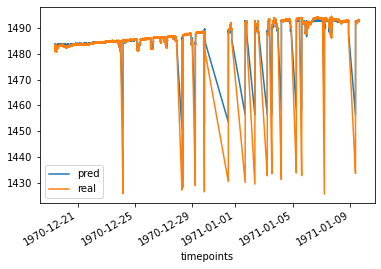

In [28]:
pred = model.predict(X_train)

rows = 3000000

pd.Series(pred[-rows:], index=y_train.iloc[-rows:].index).plot(label="pred")
y_trains[1].iloc[-rows:].plot(label="real")
plt.legend()
plt.show()

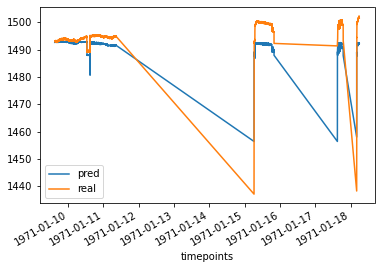

In [16]:
pred = model.predict(X_test)

pd.Series(pred, index=y_tests[1].index).plot(label="pred")
y_tests[1].plot(label="real")
plt.legend()
plt.show()

## Create Keras datasets

In [17]:
test_size = 1000

kX = df[X_cols].copy()
ky = df[y_cols]

kX_train_df, kX_test_df, ky_train_df, ky_test_df = train_test_split(kX, ky, test_percent=0.1, offset_percent=0.9)
kX_train_df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,is_starting,Netto Power,Power / vane opening,seconds_since_last_data,seconds_since_last_start,Power / Drafttube pressure
timepoints,,,,,,,,,,,,
1970-12-19 09:51:45,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,0,258.759689,3.185623,1.0,1.0,1.506435
1970-12-19 09:51:46,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,0,258.214106,3.184514,1.0,2.0,1.505561
1970-12-19 09:51:47,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,0,257.668524,3.183404,1.0,3.0,1.504687
1970-12-19 09:51:48,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,0,257.739592,3.182294,1.0,4.0,1.503294
1970-12-19 09:51:49,261.704362,3.170510,82.266336,174.422046,5312.533396,107.964254,0,258.533851,3.181184,1.0,5.0,1.500409
...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-18 18:05:29,312.468689,-3.704364,94.956253,155.826849,5295.470314,108.056636,0,316.173053,3.290659,1.0,49912.0,2.005230
1971-01-18 18:05:30,312.468689,-4.340885,94.956253,155.689861,5295.128639,108.056634,0,316.809574,3.290659,1.0,49913.0,2.006994
1971-01-18 18:05:31,312.468689,-4.990518,94.956253,155.552874,5294.786963,108.056632,0,317.459207,3.290659,1.0,49914.0,2.008762


In [18]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

ky_trains = [ky_train_df[c] for c in ky_train_df]
ky_tests = [ky_test_df[c] for c in ky_test_df]

j = 0
kX_train, ky_train = lstm_data_transform(kX_train_df, ky_trains[j], num_steps=30)
kX_test, ky_test = lstm_data_transform(kX_test_df, ky_tests[j], num_steps=30)

In [19]:
kX_train.shape

(1574934, 30, 12)

In [20]:
kX_train

array([[[ 2.62104319e+02,  3.34462989e+00,  8.22772479e+01, ...,
          1.00000000e+00,  1.00000000e+00,  1.50643484e+00],
        [ 2.62004330e+02,  3.79022336e+00,  8.22745200e+01, ...,
          1.00000000e+00,  2.00000000e+00,  1.50556077e+00],
        [ 2.61904340e+02,  4.23581683e+00,  8.22717921e+01, ...,
          1.00000000e+00,  3.00000000e+00,  1.50468704e+00],
        ...,
        [ 2.60949475e+02, -8.04132497e-01,  8.22289989e+01, ...,
          1.00000000e+00,  2.80000000e+01,  1.47320394e+00],
        [ 2.60956448e+02, -3.29792775e-01,  8.22320291e+01, ...,
          1.00000000e+00,  2.90000000e+01,  1.47332961e+00],
        [ 2.60963422e+02, -1.12188569e+00,  8.22350594e+01, ...,
          1.00000000e+00,  3.00000000e+01,  1.47306919e+00]],

       [[ 2.62004330e+02,  3.79022336e+00,  8.22745200e+01, ...,
          1.00000000e+00,  2.00000000e+00,  1.50556077e+00],
        [ 2.61904340e+02,  4.23581683e+00,  8.22717921e+01, ...,
          1.00000000e+00,  3.00000000e

## Train Keras models

In [21]:
def train_keras(first, X_train, y_train, eval_set, epochs=20, batch_size=2048):
    
    norm = Normalization()
    norm.adapt(first(X_train))
    
    model = Sequential([
        first,
        norm,
        Dense(3),
        Dropout(0.4),
        Dense(3),
        Dense(3),
        Dense(3),
        Dense(3),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    model.fit(X_train, y_train, validation_data=eval_set, epochs=epochs, batch_size=batch_size, verbose=1)
    
    return model

In [22]:
lstm_model = train_keras(
    LSTM(5, input_shape=(kX_train.shape[1], kX_train.shape[2])),
    X_train = kX_train,
    y_train = ky_train,
    eval_set = (kX_test, ky_test),
    epochs=20
)

Epoch 1/20
770/770 [==============================] - 29s 35ms/step - loss: 55.3172 - val_loss: 12.8503
Epoch 2/20
770/770 [==============================] - 25s 32ms/step - loss: 28.9652 - val_loss: 10.7866
Epoch 3/20
770/770 [==============================] - 25s 32ms/step - loss: 23.9373 - val_loss: 6.6766
Epoch 4/20
770/770 [==============================] - 27s 35ms/step - loss: 2.6716 - val_loss: 1.5566
Epoch 5/20
770/770 [==============================] - 33s 42ms/step - loss: 0.4390 - val_loss: 1.5506
Epoch 6/20
770/770 [==============================] - 41s 53ms/step - loss: 0.4375 - val_loss: 1.6946
Epoch 7/20
770/770 [==============================] - 40s 52ms/step - loss: 0.4353 - val_loss: 1.7936
Epoch 8/20
770/770 [==============================] - 37s 48ms/step - loss: 0.4369 - val_loss: 1.3445
Epoch 9/20
770/770 [==============================] - 24s 31ms/step - loss: 0.4363 - val_loss: 1.8154
Epoch 10/20
770/770 [==============================] - 25s 33ms/step - loss: 

In [23]:
gru_model = train_keras(
    GRU(10, input_shape=(kX_train.shape[1], kX_train.shape[2])),
    X_train = kX_train,
    y_train = ky_train,
    eval_set = (kX_test, ky_test),
    epochs=15
)

Epoch 1/15
770/770 [==============================] - 32s 39ms/step - loss: 54.4384 - val_loss: 11.2571
Epoch 2/15
770/770 [==============================] - 28s 36ms/step - loss: 30.3106 - val_loss: 10.9064
Epoch 3/15
770/770 [==============================] - 28s 36ms/step - loss: 28.4910 - val_loss: 10.2745
Epoch 4/15
770/770 [==============================] - 28s 36ms/step - loss: 16.4117 - val_loss: 1.6841
Epoch 5/15
770/770 [==============================] - 28s 36ms/step - loss: 0.4598 - val_loss: 1.3925
Epoch 6/15
770/770 [==============================] - 27s 36ms/step - loss: 0.4535 - val_loss: 1.4625
Epoch 7/15
770/770 [==============================] - 29s 38ms/step - loss: 0.4485 - val_loss: 1.9589
Epoch 8/15
770/770 [==============================] - 29s 38ms/step - loss: 0.4463 - val_loss: 1.4160
Epoch 9/15
770/770 [==============================] - 28s 36ms/step - loss: 0.4426 - val_loss: 1.3843
Epoch 10/15
770/770 [==============================] - 28s 36ms/step - loss

In [33]:
tcn_model = train_keras(
    TCN(nb_filters=4, input_shape=(kX_train.shape[1], kX_train.shape[2])),
    X_train = kX_train,
    y_train = ky_train,
    eval_set = (kX_test, ky_test),
    epochs=40
)

Epoch 1/40
770/770 [==============================] - 108s 138ms/step - loss: 39.8595 - val_loss: 10.7182
Epoch 2/40
770/770 [==============================] - 104s 135ms/step - loss: 31.7683 - val_loss: 10.8944
Epoch 3/40
770/770 [==============================] - 102s 133ms/step - loss: 31.5587 - val_loss: 11.0731
Epoch 4/40
770/770 [==============================] - 104s 135ms/step - loss: 31.3591 - val_loss: 11.2358
Epoch 5/40
770/770 [==============================] - 102s 132ms/step - loss: 31.2366 - val_loss: 10.1683
Epoch 6/40
770/770 [==============================] - 101s 131ms/step - loss: 31.0038 - val_loss: 11.1071
Epoch 7/40
770/770 [==============================] - 101s 131ms/step - loss: 30.7238 - val_loss: 10.7460
Epoch 8/40
770/770 [==============================] - 101s 132ms/step - loss: 30.3816 - val_loss: 10.4088
Epoch 9/40
770/770 [==============================] - 104s 135ms/step - loss: 29.7804 - val_loss: 10.8786
Epoch 10/40
770/770 [=========================